In [1]:
# Importing necessary models
import warnings
warnings.filterwarnings('ignore')

import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
import time
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import calendar
pd.options.display.float_format = '{:,.4f}'.format
from ipywidgets import interactive, HBox, VBox
init_notebook_mode(connected=True)

import statsmodels.formula.api as sm

from pandas_datareader.data import Options

import os
curr_dir = os.getcwd()
os.chdir('..//Modules//Options')

import optionsFunctions as optionsfxns

In [123]:
columns = ['Strike', 'Expiry', 'Type', 'Symbol', 'Last', 'Bid', 'Ask', 'IV', 'Root', 'Underlying_Price']
spx_tape = Options('^SPX', 'yahoo')
spx_data = spx_tape.get_all_data().reset_index()[columns].sort_values(['Expiry','Strike'])
spx_data = spx_data[(spx_data.Bid > 0) & (spx_data.Expiry > dt.datetime.today())]
spx_data['Mid'] = 0.5*(spx_data.Bid + spx_data.Ask)
spx_data['DTE'] = (spx_data['Expiry'] - dt.datetime.today()).dt.days

puts = spx_data[spx_data.Type == 'put'].sort_values(['DTE','Strike']).reset_index(drop = True)
calls = spx_data[spx_data.Type == 'call'].sort_values(['DTE','Strike']).reset_index(drop = True)
curr_spx = spx_data.loc[0,'Underlying_Price']

In [124]:
def stack_ivs(chain):
    dtes = list(chain.DTE.drop_duplicates())
    for i, dte in enumerate(dtes):
        if i == 0:
            ivs = chain[chain.DTE == dte][['Strike','IV']].set_index('Strike')
        else:
            ivs = pd.concat([ivs, 
                             chain[chain.DTE == dte][['Strike','IV']].set_index('Strike')],
                            axis = 1)
    ivs.columns = dtes
    return ivs

In [62]:
put_ivs = stack_ivs(puts)
call_ivs = stack_ivs(calls)

In [125]:
ivs = put_ivs.copy()

i = 1
curr_ivs = ivs[[i]].dropna()
curr_x = pd.DataFrame(curr_ivs.index/spx_data.loc[0,'Underlying_Price'] - 1)
curr_x['Strike2'] = curr_x.Strike**2
curr_x['Intercept'] = 1
curr_params = np.dot(np.linalg.pinv(curr_x.T.dot(curr_x)),curr_x.T.dot(curr_ivs.as_matrix()))
curr_params = pd.DataFrame(curr_params.T, columns = ['return','return2','intercept'])
curr_params['min_iv_return'] = -curr_params.loc[0,'return']/(2*curr_params.loc[0,'return2'])

curr_ivs_upper = curr_ivs[curr_ivs.index > curr_spx*(1 + curr_params.loc[0,' min_iv_return'])]

return  return2  intercept  min_iv_return
0 -1.5731  12.6751     0.1174         0.0621

In [353]:
i = 20

calls = spx_data[(spx_data['Expiry'] == expirations.iloc[20,0]) &
                 (spx_data['Type'] == 'call')].reset_index(drop = True)
puts = spx_data[(spx_data['Expiry'] == expirations.iloc[20,0]) &
                 (spx_data['Type'] == 'put')].reset_index(drop = True)

In [274]:
options_df = calls.copy()

time_range = 5
dte_range = (options_df.loc[0,'Expiry'] - dt.datetime.today()).days
dte_range = np.arange(max(0, dte_range - time_range), dte_range + time_range)
dte_price_errors = []

for dte in dte_range:
    curr_options = options_df[abs(1 - options_df.Strike/options_df.Underlying_Price) < 0.01]
    curr_options['DTE'] = dte
    curr_prices = optionsfxns.black_scholes_merton(curr_options, interest_rate = 0, q = 0, year = 365.25)
    curr_differences = sum(abs((curr_prices['Mid'] - curr_prices['Simulated Prices'])))/len(curr_prices)
    dte_price_errors.append(curr_differences)
dte_price_errors = pd.DataFrame({'Price_Diffs': dte_price_errors,
                                 'DTE': dte_range}, index = range(len(dte_range))).sort_values('Price_Diffs').head()

In [275]:
curr_ivs = pd.concat([puts[puts.Strike <= puts.Underlying_Price][['Strike','IV']],
                      calls[calls.Strike > calls.Underlying_Price][['Strike','IV']]], 
                     axis = 0).set_index('Strike')

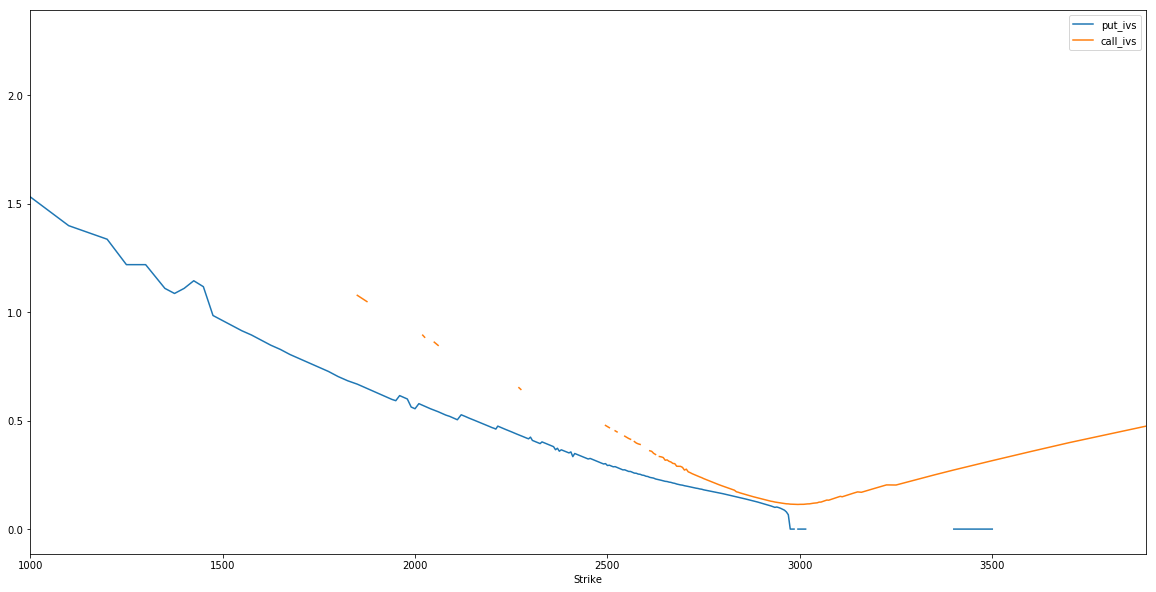

In [363]:
i = 5

calls = spx_data[(spx_data['Expiry'] == expirations.iloc[i,0]) &
                 (spx_data['Type'] == 'call')].reset_index(drop = True)
puts = spx_data[(spx_data['Expiry'] == expirations.iloc[i,0]) &
                 (spx_data['Type'] == 'put')].reset_index(drop = True)

stacked_ivs = pd.concat([puts[['Strike','IV']].set_index('Strike'),
                         calls[['Strike','IV']].set_index('Strike')], axis = 1)
stacked_ivs.columns = ['put_ivs','call_ivs']
stacked_ivs.plot(figsize = (20,10))

In [498]:
def get_iv_function(spx_data, i):
    calls = spx_data[(spx_data['Expiry'] == expirations.iloc[i,0]) &
                 (spx_data['Type'] == 'call')].reset_index(drop = True)
    puts = spx_data[(spx_data['Expiry'] == expirations.iloc[i,0]) &
                     (spx_data['Type'] == 'put')].reset_index(drop = True)
    
    curr_ivs = pd.concat([puts[puts.Strike <= puts.Underlying_Price][['Strike','IV']],
                          calls[calls.Strike > calls.Underlying_Price][['Strike','IV']]], 
                         axis = 0).set_index('Strike')
    strike_ret = curr_ivs.index/spx_data.loc[0,'Underlying_Price'] - 1
    x_vals = pd.DataFrame({'x2': strike_ret**2})
    x_vals['x'] = strike_ret
    x_vals['intercept'] = 1
    iv_coeffs = np.linalg.inv((np.dot(x_vals.T,x_vals))).dot(x_vals.T.as_matrix()).dot(curr_ivs)
    return iv_coeffs

In [502]:
iv_coeffs_df = pd.DataFrame(columns = ['x2','x','intercept'])

for i in expirations.index:
    curr_coeffs = pd.DataFrame(get_iv_function(spx_data, i).T)
    curr_coeffs.columns = ['x2','x','intercept']
    iv_coeffs_df = iv_coeffs_df.append(curr_coeffs)

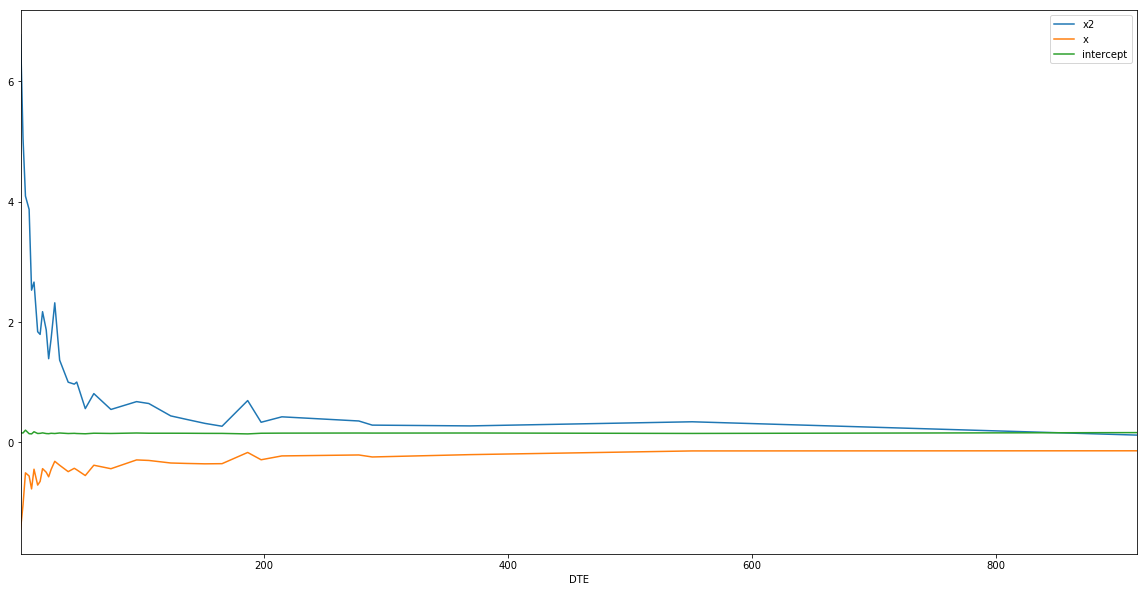

In [508]:
iv_coeffs_df.set_index(expirations.DTE).plot(figsize = (20,10))

In [374]:
options_lst = []
for i in expirations.index:
    current_expiry = expirations.iloc[i,0]
    curr_calls = spx_data[(spx_data.Type == 'call') &
                          (spx_data.Expiry == current_expiry) &
                          (spx_data.Strike > spx_data.Underlying_Price)].sort_values(['Expiry','Strike'])[['Strike','IV']]
    curr_puts = spx_data[(spx_data.Type == 'put') &
                          (spx_data.Expiry == current_expiry) &
                          (spx_data.Strike <= spx_data.Underlying_Price)].sort_values(['Expiry','Strike'])[['Strike','IV']]
    curr_options = pd.concat([curr_puts,curr_calls], axis = 0).sort_values('Strike').set_index('Strike')
    curr_options.columns = [current_expiry.date()]
    options_lst.append(curr_options)

In [375]:
ivs_surface = pd.concat(options_lst,axis = 1)

In [469]:
pct_change_down = 0.5
pct_change_up = 0.3
returns_spacing = 100
curr_spx = spx_data.loc[0,'Underlying_Price']
spx_range = np.linspace(curr_spx*(1 - pct_change_down), curr_spx*(1 + pct_change_up), spacing)

days_remaining_end = 200
days_remaining_start = 50
days_remaining_spacing = 100

expiry_range = np.repeat(np.linspace(days_remaining_start, 
                                     days_remaining_end,
                                     days_remaining_spacing), 
                         returns_spacing)
spx_simulations = pd.DataFrame({'Spot': np.tile(spx_range, days_remaining_spacing),
                                'DTE': expiry_range})

In [470]:
all_ivs = pd.merge(spx_data[(spx_data.Type == 'put') &
                            (spx_data.Ask > 0.05)][['Strike','DTE','IV']],
                   spx_data[(spx_data.Type == 'call') &
                            (spx_data.Ask > 0.05)][['Strike','DTE','IV']],
                   how = 'outer',
                   on = ['Strike','DTE'],
                   suffixes = ['_put','_call']).sort_values(['DTE','Strike']).reset_index(drop = True)
all_ivs['IV_implied'] = all_ivs[['IV_put','IV_call']].max(axis = 1)
x_vals = all_ivs[['Strike']]/curr_spx - 1
x_vals.columns = ['x']
x_vals['t'] = all_ivs.DTE/365.25
x_vals['x4'] = x_vals.x**4
x_vals['x3'] = x_vals.x**3
x_vals['x2'] = x_vals.x**2

x_vals['t2'] = x_vals.t**2
x_vals['x2t'] = x_vals.x**2*x_vals.t
x_vals['xt2'] = x_vals.x*x_vals.t**2
x_vals['xt'] = x_vals.x*x_vals.t
x_vals['intercept'] = 1



regressor_OLS = sm.OLS(endog = all_ivs.IV_implied, exog = x_vals).fit()

In [471]:
sim_x = spx_simulations[['Spot']]/curr_spx - 1
sim_x.columns = ['x']
sim_x['t'] = spx_simulations.DTE/365.25
sim_x['x4'] = sim_x.x**4
sim_x['x3'] = sim_x.x**3
sim_x['x2'] = sim_x.x**2

sim_x['t2'] = sim_x.t**2
sim_x['x2t'] = sim_x.x**2*sim_x.t
sim_x['xt2'] = sim_x.x*sim_x.t**2
sim_x['xt'] = sim_x.x*sim_x.t
sim_x['intercept'] = 1

In [477]:
spx_simulations['Simulated IV'] = regressor_OLS.predict(sim_x)

In [491]:
x, y = np.meshgrid(spx_simulations.DTE.drop_duplicates(), spx_simulations.Spot.drop_duplicates())

z = spx_simulations['Simulated IV'].reshape(x.shape)

In [497]:
data = [
    go.Surface(
        x=x,
        y=y,
        z=z
    )
]
layout = go.Layout(
    title='IV Surface',
    scene=dict(
        xaxis=dict(title='DTE'),
        yaxis=dict(title='Strike'),
        zaxis=dict(title='IV')
        ),
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [19]:
data = [dict(
        visible = False,
        line = dict(color='#00CED1', width=6),
        name = '𝜈 = '+ str(step),
        x = np.arange(0,10,0.01),
        y = np.sin(step*np.arange(0,10,0.01))) for step in np.arange(0,5,0.1)]
data[10]['visible'] = True


steps = []
for i in range(len(data)):
    step = dict(
        method = 'restyle',  
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active = 10,
    currentvalue = {"prefix": "Frequency: "},
    pad = {"t": 50},
    steps = steps
)]

layout = dict(sliders=sliders)

fig = dict(data=data, layout=layout)

iplot(fig, filename='Sine Wave Slider')

In [140]:
from miraepy.derivatives.params.impliedvol_all import ImpliedVolSurface

ModuleNotFoundError: No module named 'miraepy'